In [13]:
# Import namespaces
import sys
import os
import math
import itertools
import json
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandapower as pp
from scipy.optimize import linprog, minimize
from scipy.optimize import NonlinearConstraint
import scipy.integrate as integrate

from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multinomial
from scipy.linalg import pinvh
from pandapower import networks

from tqdm.notebook import tqdm, trange
import time 

# Setting up polytope

In [2]:
##### Setup Grid fluctuation parameters and constraints ########

## Std considered to be 1: 

cov_std = 1

### Number of samples used in experiments
### 500 is often enough
### 10000 is a default value supresses the variance

### Step-sizes for KL and Var minimization 
### works well with 0.1-0.01

eta_vm = 0.1; 
eta_kl = 0.1; 

### Rounding threshold in optimization: 
### if a (normalized on the simplex) hpl probability becomes lower then 0.001
### we increase it to this level
###
### Crucially affects numerical stability
###

eps = 0.001

In [3]:
##### Setup regular polytope ########
### number of planes and distance
J = 5
tau = 3


### Matrix 
x_An = []
### Matrix rows
for i in range(J):
    x_An.append([math.sin(2 * math.pi * i / (J - 1)), math.cos(2 * math.pi * i / (J - 1))])
x_An = np.array(x_An)
### Distances
x_bn = np.ones(J) * tau
n = x_An.shape[1]

# Outer Polyhedral Approximation -- Solving Linear Program

In [4]:
### Solving linear program
### c^T gens -> min
### s.t. A_n gens <= b_n + \Phi^{-1}(eta)
### l <= gens <= u *
### * in such a way that only net.gen['bus'] are non-zero
eta = 0.05
cost_coeffs = np.ones(n)
l = -np.ones(x_An.shape[1]) * np.inf
u = np.ones(x_An.shape[1]) * np.inf
res = linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)

obj: -2.7102927460863295
x: [-1.35514637 -1.35514637]


# Scenario Approximation

In [59]:
nsmp_list = [10, 50, 100, 200, 500]
n_tries = 50
hist_data = {nsmp: {'obj': [], 'x': [], 'time': []} for nsmp in nsmp_list}

In [62]:
# frist solve with small number, then, state the problem with more constraint with previous point obtained (warm start)
for nsmp in nsmp_list:
    for i in range(n_tries):
        t1 = time.time()
        Xi = [np.random.normal(0, 1, x_An.shape[1]) for i in range(nsmp)]
        x_An_scenario = np.concatenate([x_An for i in range(nsmp)])
        x_bn_scenario = np.concatenate([x_bn + Xi[i] for i in range(nsmp)])
        cost_coeffs = np.ones(n)
        l = -np.ones(x_An.shape[1]) * np.inf
        u = np.ones(x_An.shape[1]) * np.inf
        res = linprog(c = cost_coeffs, A_ub = x_An_scenario, b_ub = x_bn_scenario, bounds=[(l[i], u[i]) for i in range(len(l))])
        t2 = time.time()
        #print("obj:", res.fun)
        #print("x:", res.x)
        #print("time:", t2 - t1, "(s)")
        hist_data[nsmp]['obj'].append(res.fun)
        hist_data[nsmp]['x'].append(res.x)
        hist_data[nsmp]['time'].append(t2 - t1)

<ipython-input-62-70ddb8d03ba4>:10: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = linprog(c = cost_coeffs, A_ub = x_An_scenario, b_ub = x_bn_scenario, bounds=[(l[i], u[i]) for i in range(len(l))])
<ipython-input-62-70ddb8d03ba4>:10: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = linprog(c = cost_coeffs, A_ub = x_An_scenario, b_ub = x_bn_scenario, bounds=[(l[i], u[i]) for i in range(len(l))])
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.73258e-20): result may not be accurate.
  return sp.lin

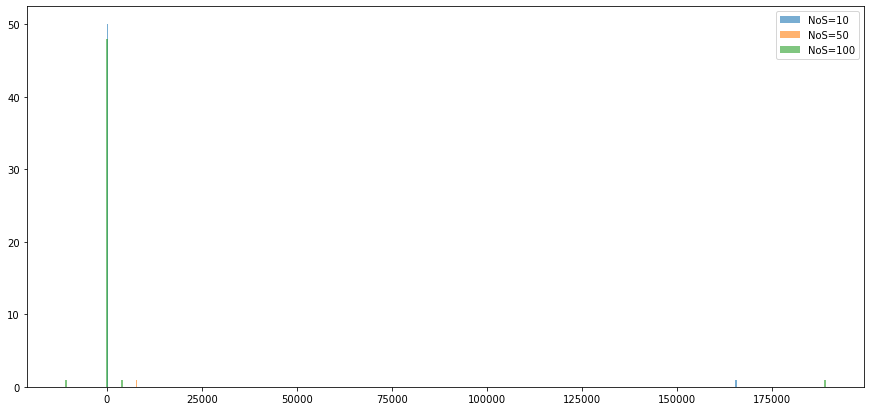

In [77]:
plt.figure(figsize=(15,7))
for nsmp in hist_data.keys():
    if nsmp <= 100:
        plt.hist(hist_data[nsmp]['obj'], label='NoS=' + str(nsmp), alpha=0.6, bins=500)
plt.legend()
plt.show()

# Ground truth -- has not been solved

\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \mathbb{P} (a_i^\top x - d_i \leq \xi_i) \geq 1 - \eta, ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}

The L.H.S of each constraint can be rewritten as 
$$
\mathbb{P} (a_i^\top x - d_i \leq \xi_i) = \mathbb{P} (-\xi_i \leq - a_i^\top x + d_i) = \texttt{cdf}_{\mathcal{N}(0, 1)} (- a_i^\top x + d_i).
$$
Thus, the problem can be reformulated as follows:
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \texttt{cdf}_{\mathcal{N}(0, 1)} (- a_i^\top x + d_i) \geq 1 - \eta, ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \texttt{cdf}_{\mathcal{N}(0, 1)} (a_i^\top x - d_i) \leq \eta, ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}

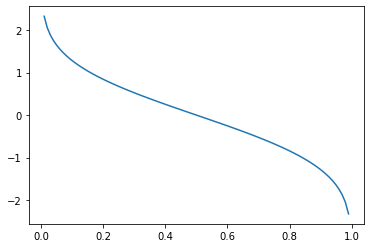

In [2]:
# - \Phi^{-1}(\eta)
xs = np.linspace(0, 1, 100)
ys = [-norm.ppf(x) for x in xs]
plt.plot(xs, ys)

In [125]:
def cdf_from_row(x, i):
    return norm.cdf( -np.dot(x_An[i], x) + x_bn[i])
def pdf_from_row(x, i):
    return -x_An[i] * norm.pdf( -np.dot(x_An[i], x) + x_bn[i])
def objective(c, x):
    return np.dot(c, x)

In [139]:
def objective_barrier(x):
    return np.dot(cost_coeffs, x) - np.sum([np.log(-1 + cdf_from_row(x, i) + eta)])

In [144]:
eta = 0.1
cost_coeffs = np.ones(n)
l = -np.ones(x_An.shape[1]) * np.inf
u = np.ones(x_An.shape[1]) * np.inf
nl_constraints = []
for i in range(len(x_bn)):
    nl_constraints.append(NonlinearConstraint(lambda x: cdf_from_row(x, i), 1. - eta, 1., jac=lambda x: pdf_from_row(x, i), keep_feasible=True))

    
res = minimize(fun=lambda x: objective(cost_coeffs, x), x0=[0.0, 0.0], constraints=nl_constraints, method='trust-constr')
#linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


obj: -285.0918011583807
x: [-286.28412876    1.1923276 ]


In [143]:
for i in range(len(x_bn)):
    print(cdf_from_row(res.x, i))

1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0


# Markov
The constraints can be approximated as convex Markov's approximation:
$$
\mathbb{E} ( - \xi_i + a_i^\top - d_i + t_i)_+ \leq \eta t_i, ~i=1,\dots, m.
$$
Further, computing the expectation in the left hand side, one can obtain
$$
-\frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} (a_i^\top x - d_i + t_i)^2} + (a_i^\top x - d_i + t_i) (1 - \texttt{cdf}_{\mathcal{N}(0,1)}(- a_i^\top x + d_i - t_i)) \leq \eta t_i
$$

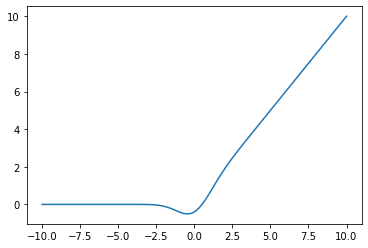

In [6]:
def markov_constr_1d(x):
    first = - 1 / np.sqrt(2 * np.pi) * np.exp(- 0.5 * (x)**2)
    second = (x) * norm.cdf(x)
    return first + second
xs = np.linspace(-10, 10, 100)
ys = [markov_constr_1d(x) for x in xs]
plt.plot(xs, ys)

In [150]:
def markov_constr(var, i):
    x = var[:2]
    t = var[2:][i]
    first = - 1 / np.sqrt(2 * np.pi) * np.exp(- 0.5 * (np.dot(x_An[i], x) - x_bn[i] + t)**2)
    second = (np.dot(x_An[i], x) - x_bn[i] + t) * norm.cdf(x_An[i] - x_bn[i] + t) - eta * t
    return first + second
def objective_markov(x):
    return np.dot(cost_coeffs, x[:2])

In [153]:
eta = 0.1
cost_coeffs = np.ones(n)
nl_constraints = []
for i in range(len(x_bn)):
    nl_constraints.append(NonlinearConstraint(lambda x: markov_constr(x, i), -np.inf, 0., keep_feasible=True))

    
res = minimize(fun=lambda x: objective_markov(x), x0=np.zeros(2 + J), constraints=nl_constraints, method='trust-constr')
#linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)
print("success:", res.success)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


obj: -34063480.73912658
x: [-12525083.20352325 -21538397.53560333         0.
         0.                 0.                 0.
         0.                 0.                 0.
         0.                 0.           4722263.45985914]


# Chebyshev
The constraints can be approximated as convex Chebyshev's approximation:
$$
\mathbb{E} ( - \xi_i + a_i^\top - d_i + t_i)^2_+ \leq \eta t_i, ~i=1,\dots, m.
$$
Further, computing the expectation in the left hand side, one can obtain
$$
- \frac{1}{\sqrt{2 \pi}} \alpha_i(x) e^{-\frac{\alpha_i^2(x)}{2}} + \texttt{cdf}_{\mathcal{N}(0,1)}(- \alpha_i(x)) (1 + \alpha_i^2(x)) - 2 \alpha_i(x) \left( \frac{1}{\sqrt{2\pi}} e^{-\frac{\alpha_i^2(x)}{2}} \right) - \eta t_i^2,
$$
where $\alpha_i(x) = a_i^\top x - d_i + t_i$

# Chernoff
The constraints can be approximated as convex Chernoff's approximation:
$$
\log \mathbb{E} \exp \left( (\xi_i - a_i^\top x + d_i)/ t_i \right) \leq \log \eta
$$
Further, simplifying the L.H.S., one can obtain
$$
\frac{- a_i^\top x + d_i}{t_i} + \log \mathbb{E} \exp (\xi_i / t_i).
$$
The last term is the cumulant generating function of $\xi_i \sim \mathcal{N}(0,1)$ evaluated at $t_i$. Thus, the constraints can be approximated as follows:
$$
\frac{- a_i^\top x + d_i}{t_i} + \frac{t_i^2}{2} \leq \log \eta
$$


In [ ]:
# rewrite constraints 
#boyd lectures - check
#nemirovsky lectures - chekc
# laurent el ghaoui

# Joint CC - Ground Truth
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \mathbb{P} \{ \max_i (a_i^\top x - d_i - \xi_i) \leq 0 \} \geq 1 - \eta,
    \end{aligned}
$$
Here $\xi_i \sim \mathcal{N}(0,1)$. Thus, $a_i^\top x - d_i - \xi_i \sim \mathcal{N}(a_i^\top x - d_i, 1)$. Hence, 
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \texttt{cdf}_{\mathcal{N}\left(\max_i (a_i^\top x - d_i), 1\right)}(0) \geq 1 - \eta,
    \end{aligned}
$$

In [10]:
def joint_cc_gt(x):
    vec = np.dot(x_An, x) - x_bn
    mean = np.max(vec)
    return norm(mean, 1).cdf(0)
def objective(c, x):
    return np.dot(c, x)

In [15]:
eta = 0.05
cost_coeffs = np.ones(n)
nl_constraints = [NonlinearConstraint(joint_cc_gt, lb = [1. - eta], ub=[1], keep_feasible=True)]
res = minimize(fun=lambda x: objective(cost_coeffs, x), x0=[0.0, 0.0], constraints=nl_constraints, method='trust-constr')
#linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


obj: -2.699362134353054
x: [-1.35092234 -1.34843979]


In [16]:
joint_cc_gt(res.x)

0.950434136962111

# Joint CC - Markov
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \mathbb{E} \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) + t \right)_+ \leq \eta t,
    \end{aligned}
$$

In [125]:
def jcc_markov_under_exp(x, t, xi):
    ### xi - is a vector of len(x_bn)!!!
    vec = np.dot(x_An, x) - x_bn - xi
    max_val = np.max(vec)
    return np.max((max_val + t), 0)

def jcc_markov_exp(x, t):
    res = integrate.quad(lambda xi: jcc_markov_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)
    return res[0]
def jcc_markov_constr(var):
    x = var[:n]
    t = var[-1]
    return jcc_markov_exp(x, t) - eta * t
def objective_markov(c, x):
    return np.dot(c, x[:n])
def objective_markov_barrier(c, x):
    return np.dot(c, x[:n]) + 20000 * np.max((0.,jcc_markov_constr(x))) ** 2 #- np.log(-jcc_markov_constr(x))

In [126]:
eta = 0.1
cost_coeffs = np.ones(n)
res = minimize(fun=lambda x: objective_markov_barrier(cost_coeffs, x), x0=[0.0, 0.0, 0.0], method='Nelder-Mead')
#linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)

obj: -3.409202787723539
x: [-1.70465189 -1.70461218  1.43933718]


In [127]:
print("constraint value =", jcc_markov_constr(res.x))
print("original constraint value =", joint_cc_gt(res.x[:2]))

constraint value = 5.535398686362658e-05
original constraint value = 0.9023999155263599


# Joint CC - Chebyshev
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \mathbb{E} \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) + t \right)^2_+ \leq \eta t^2,
    \end{aligned}
$$

In [131]:
def jcc_chebyshev_under_exp(x, t, xi):
    ### xi - is a vector of len(x_bn)!!!
    vec = np.dot(x_An, x) - x_bn - xi
    max_val = np.max(vec)
    return np.max((max_val + t), 0) ** 2

def jcc_chebyshev_exp(x, t):
    res = integrate.quad(lambda xi: jcc_chebyshev_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)
    return res[0]
def jcc_chebyshev_constr(var):
    x = var[:n]
    t = var[-1]
    return jcc_chebyshev_exp(x, t) - eta * t ** 2
def objective_chebyshev(c, x):
    return np.dot(c, x[:n])
def objective_chebyshev_barrier(c, x):
    return np.dot(c, x[:n]) + 10000 * np.max((0.,jcc_chebyshev_constr(x))) ** 2 #- np.log(-jcc_markov_constr(x))

In [132]:
eta = 0.1
cost_coeffs = np.ones(n)
res = minimize(fun=lambda x: objective_chebyshev_barrier(cost_coeffs, x), x0=[0.0, 0.0, 0.0], method='Nelder-Mead')
#linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)

obj: 1.8527826858419296
x: [ 0.01223327 -0.01263649  3.24323291]


In [133]:
print("constraint value =", jcc_chebyshev_constr(res.x))
print("original constraint value =", joint_cc_gt(res.x[:n]))

constraint value = 0.013613177075289418
original constraint value = 0.9985930254475449


# Joint CC - Chernoff
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \log \mathbb{E} \exp \left( \max_i\left[\xi_i - a_i^\top x + d_i\right]/ t \right) \leq \log \eta,
    \end{aligned}
$$


In [142]:
def jcc_chernoff_under_exp(x, t, xi):
    ### xi - is a vector of len(x_bn)!!!
    vec = np.dot(x_An, x) - x_bn - xi
    max_val = np.max(vec)
    return np.exp(max_val / t)

def jcc_chernoff_exp(x, t):
    res = integrate.quad(lambda xi: jcc_chernoff_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)
    return res[0]
def jcc_chernoff_constr(var):
    x = var[:n]
    t = var[-1]
    return np.log(jcc_chernoff_exp(x, t)) - np.log(eta)
def objective_chernoff_barrier(c, x):
    return np.dot(c, x[:n]) + 1000 * np.max((0.,jcc_chernoff_constr(x))) ** 2 #- np.log(-jcc_markov_constr(x))

In [143]:
eta = 0.1
cost_coeffs = np.ones(n)
res = minimize(fun=lambda x: objective_chernoff_barrier(cost_coeffs, x), x0=[0.0, 0.0, 1.0], method='Nelder-Mead')
#linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
print("obj:", res.fun)
print("x:", res.x)

<ipython-input-142-8e57c903d54c>:5: RuntimeWarning: overflow encountered in exp
  return np.exp(max_val / t)
<ipython-input-142-8e57c903d54c>:8: RuntimeWarning: invalid value encountered in double_scalars
  res = integrate.quad(lambda xi: jcc_chernoff_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)
<ipython-input-142-8e57c903d54c>:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = integrate.quad(lambda xi: jcc_chernoff_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)


obj: nan
x: [0. 0. 1.]


In [144]:
print("constraint value =", jcc_chernoff_constr(res.x))
print("original constraint value =", joint_cc_gt(res.x[:n]))

constraint value = nan
original constraint value = 0.9986501019683699


<ipython-input-142-8e57c903d54c>:5: RuntimeWarning: overflow encountered in exp
  return np.exp(max_val / t)
<ipython-input-142-8e57c903d54c>:8: RuntimeWarning: invalid value encountered in double_scalars
  res = integrate.quad(lambda xi: jcc_chernoff_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)
<ipython-input-142-8e57c903d54c>:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = integrate.quad(lambda xi: jcc_chernoff_under_exp(x, t, xi) / np.sqrt(2 * np.pi) * np.exp(- 0.5 * xi**2), -np.inf, +np.inf)
